This notebook is for comparing the gap filling techniques visually

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [12]:
# First import the model
from modules.models import MLP
from modules.util import grab_data

In [13]:
# Load the data on which predictions and or gap filling are to be done
data_columns = ['CO2', 'H2O', 'Ustar', 'location', 'year', 'month', 'day', '30min']
input, target, dim_in, dim_out = grab_data('data/data_files_modified/GW_fluxes_30min_20240401_20240608_mod.csv', return_dataset = False )

In [14]:
# Load the model
model = MLP(dim_in, dim_out, num_hidden_units=30, num_hidden_layers=4)
model.load_state_dict(torch.load('model_saves/mlp_1.pth'))
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=2, bias=True)
  )
)

In [15]:
# Get an overview about NaNs per Row to remove input data nans
nan_counts = input.isnull().sum()
print("NaNs per column:")
print(nan_counts)

NaNs per column:
CO2         663
H2O         665
Ustar        85
location      0
year          0
month         0
day           0
30min         0
dtype: int64


In [16]:
# Identify the rows where the input data is missing and remove the faulty rows from both frames
valid_rows = input.dropna(subset=['CO2','H2O','Ustar']).index
input = input.loc[valid_rows]
target = target.loc[valid_rows]

In [17]:
# Now identify the rows where gaps are present in the H & LE which can be filled by our model & data
target_nan_indices = target[target.isnull().any(axis=1)].index
# Only use commplete data at the missing rows to predict
input = input.loc[target_nan_indices]
print(target_nan_indices)

Index([  22,   24,   61,   69,   71,   76,   78,  110,  125,  127,
       ...
       3197, 3201, 3236, 3237, 3238, 3239, 3240, 3243, 3244, 3248],
      dtype='int64', length=231)


In [18]:
# transform input into torch.tensor and make predictions
input_tensor = torch.tensor(input.values, dtype=torch.float32)

with torch.no_grad():
    pred = model(input_tensor).numpy() #  Transform back to numpy 
# create dataframe of predictions with target rows and the indices of the missing values
pred = pd.DataFrame(pred, columns=target.columns, index=target_nan_indices)

pred.head()

,H_orig,LE_orig
22,12.363419,17.438421
24,12.439116,17.496122
61,9.314765,15.341798
69,9.597750,15.552306
71,9.750642,15.669014


In [19]:
# Merge the predicted results into the target dataframe
for col in target.columns:
    target.loc[target_nan_indices, col] = pred.loc[target_nan_indices, col]

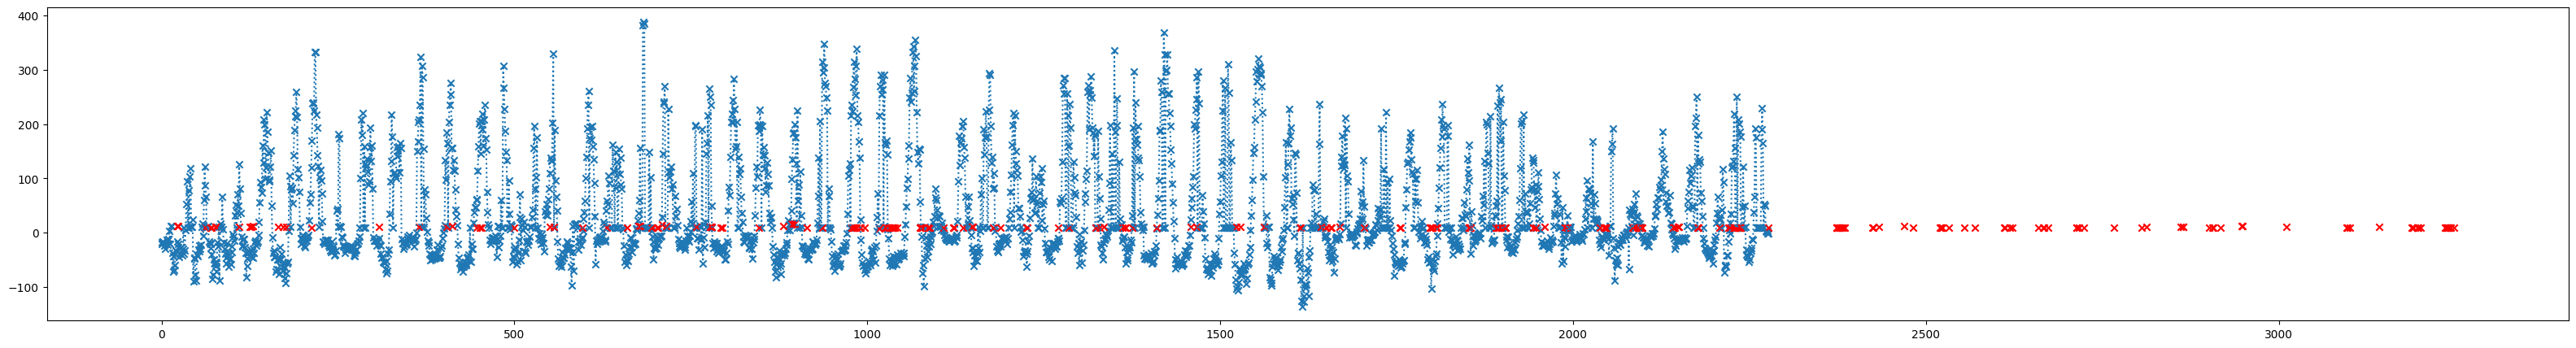

In [20]:
# Create plots of the filled frame

time = np.arange(len(target))

plt.figure(figsize=(40,5))
plt.scatter(time, target['H_orig'].to_numpy(), marker='x')
plt.plot(time, target['H_orig'].to_numpy(), linestyle='dotted' )
plt.scatter(target_nan_indices.to_numpy(), target['H_orig'].loc[target_nan_indices].to_numpy(), color='red', marker='x')